# Assignment 3 : Sequence labelling with RNNs
In this assignement we will ask you to perform POS tagging.

You are asked to follow these steps:
*   Download the corpora and split it in training and test sets, structuring a dataframe.
*   Embed the words using GloVe embeddings
*   Create a baseline model, using a simple neural architecture
*   Experiment doing small modifications to the model
*   Evaluate your best model
*   Analyze the errors of your model

**Corpora**:
Ignore the numeric value in the third column, use only the words/symbols and its label.
https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip 

**Splits**: documents 1-100 are the train set, 101-150 validation set, 151-199 test set.

**Baseline**: two layers architecture: a Bidirectional LSTM and a Dense/Fully-Connected layer on top.
**Modifications**: experiment using a GRU instead of the LSTM, adding an additional LSTM layer, and using a CRF in addition to the LSTM. Each of this change must be done by itself (don't mix these modifications).<br>
1) BiLSTM +  FC <br>
2) BiGRU + FC <br>
3) BiLSTMx2 + FC <br>
4) BiLSTM +  FC + CRF <br>
**Training and Experiments**: all the experiments must involve only the training and validation sets.

**Evaluation**: in the end, only the best model of your choice must be evaluated on the test set. The main metric must be F1-Macro computed between the various part of speech (without considering punctuation classes).

**Error Analysis** (optional) : analyze the errors done by your model, try to understand which may be the causes and think about how to improve it.

**Report**: You are asked to deliver a small report of about 4-5 lines in the .txt file that sums up your findings.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext

from torchtext import data
from torchtext import datasets

import spacy
import numpy as np

import time
import random
import os
import matplotlib.pyplot as plt

### Read Data

In [2]:
def read_data(base_dir, datafields):
    train = []
    val = []
    test = []
    for filename in sorted(os.listdir(base_dir)):
        if str(filename) < 'wsj_0100.dp': # get train data
            with open(base_dir + filename, encoding='utf-8') as f:
                words = []
                labels = []
                for line in f:
                    line = line.strip()
                    if line: # if is not empty string
                        columns = line.split()
                        words.append(columns[0]) # take the word
                        labels.append(columns[-2]) # take the POS tag
                train.append(torchtext.data.Example.fromlist([words, labels], datafields))
        elif str(filename) < 'wsj_0150.dp': # get val data
            with open(base_dir + filename, encoding='utf-8') as f:
                words = []
                labels = []
                for line in f:
                    line = line.strip()
                    if line: # if is not empty string
                        columns = line.split()
                        words.append(columns[0]) # take the word
                        labels.append(columns[-2]) # take the POS tag
                val.append(torchtext.data.Example.fromlist([words, labels], datafields))
        else: # get test data
            with open(base_dir + filename, encoding='utf-8') as f:
                words = []
                labels = []
                for line in f:
                    line = line.strip()
                    if line: # if is not empty string
                        columns = line.split()
                        words.append(columns[0]) # take the word
                        labels.append(columns[-2]) # take the POS tag
                test.append(torchtext.data.Example.fromlist([words, labels], datafields))
    return torchtext.data.Dataset(train, datafields), torchtext.data.Dataset(val, datafields), torchtext.data.Dataset(test, datafields)

### Train and evaluate utility functions

In [3]:
def categorical_accuracy(preds, y, tag_pad_idx):
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    non_pad_elements = (y != tag_pad_idx).nonzero()
    correct = max_preds[non_pad_elements].squeeze(1).eq(y[non_pad_elements])
    return correct.sum() / torch.FloatTensor([y[non_pad_elements].shape[0]])

def train(model, iterator, optimizer, criterion, tag_pad_idx):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        text = batch.text
        tags = batch.label
        
        optimizer.zero_grad()
        predictions = model(text)
        predictions = predictions.view(-1, predictions.shape[-1])
        tags = tags.view(-1)
        
        loss = criterion(predictions, tags)
                
        acc = categorical_accuracy(predictions, tags, tag_pad_idx)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, tag_pad_idx):
    
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text = batch.text
            tags = batch.label
            
            predictions = model(text)
            
            predictions = predictions.view(-1, predictions.shape[-1])
            tags = tags.view(-1)
            
            loss = criterion(predictions, tags)
            
            acc = categorical_accuracy(predictions, tags, tag_pad_idx)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [4]:
text = data.Field(lower = True)
label = data.Field(unk_token = None)
fields = [('text', text), ('label', label)]
base_dir = 'dependency_treebank/'
train_data, val_data, test_data = read_data(base_dir, fields)

In [5]:
MIN_FREQ = 2

text.build_vocab(train_data, 
                 min_freq = MIN_FREQ,
                 vectors = "glove.6B.100d",
                 unk_init = torch.Tensor.normal_)

label.build_vocab(train_data)

### Create train, val and test iterator

In [6]:
BATCH_SIZE = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, val_data, test_data),
    batch_size = BATCH_SIZE,
    device = device,
    sort_key = lambda x: len(x.text),
    sort_within_batch=False,
    repeat=False,
    shuffle=True)

## BiLSTM + FC model

In [38]:
class BiLSTM(nn.Module):
    def __init__(self, 
                 input_dim, 
                 embedding_dim, 
                 hidden_dim, 
                 output_dim, 
                 dropout, 
                 pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx = pad_idx)
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embedding_dim, 
                            hidden_dim, 
                            num_layers = 1, 
                            bidirectional = True)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        # pass text through embedding layer
        embedded = self.dropout(self.embedding(text))
        # pass embeddings into LSTM
        outputs, (hidden, cell) = self.lstm(embedded)
        predictions = self.fc(self.dropout(outputs))
        return predictions

INPUT_DIM = len(text.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = len(label.vocab)
DROPOUT = 0.25
PAD_IDX = text.vocab.stoi[text.pad_token]
TAG_PAD_IDX = label.vocab.stoi[label.pad_token]

model = BiLSTM(INPUT_DIM, 
                        EMBEDDING_DIM, 
                        HIDDEN_DIM, 
                        OUTPUT_DIM, 
                        DROPOUT, 
                        PAD_IDX)

# Initialization
pretrained_embeddings = text.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
optimizer = optim.Adam(model.parameters())
TAG_PAD_IDX = label.vocab.stoi[label.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)
model = model.to(device)
criterion = criterion.to(device)

### Train

In [39]:
N_EPOCHS = 25

best_valid_loss = float('inf')
train_loss_accum1, val_loss_accum1 = [], []
for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, TAG_PAD_IDX)
    valid_loss = evaluate(model, valid_iterator, criterion, TAG_PAD_IDX)
    # save train/val loss and accuracy to plot
    train_loss_accum1.append(train_loss)
    val_loss_accum1.append(valid_loss)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f})
    print(f'\t Val. Loss: {valid_loss:.3f})

Epoch: 01 | Epoch Time: 0m 36s
	Train Loss: 3.171 | Train Acc: 17.36%
	 Val. Loss: 2.755 |  Val. Acc: 27.02%
Epoch: 02 | Epoch Time: 0m 39s
	Train Loss: 2.506 | Train Acc: 35.13%
	 Val. Loss: 2.162 |  Val. Acc: 45.02%
Epoch: 03 | Epoch Time: 0m 44s
	Train Loss: 1.929 | Train Acc: 50.04%
	 Val. Loss: 1.614 |  Val. Acc: 57.37%
Epoch: 04 | Epoch Time: 1m 7s
	Train Loss: 1.487 | Train Acc: 60.57%
	 Val. Loss: 1.287 |  Val. Acc: 67.99%
Epoch: 05 | Epoch Time: 0m 37s
	Train Loss: 1.226 | Train Acc: 68.05%
	 Val. Loss: 1.081 |  Val. Acc: 71.75%
Epoch: 06 | Epoch Time: 0m 26s
	Train Loss: 1.059 | Train Acc: 71.49%
	 Val. Loss: 0.953 |  Val. Acc: 74.31%
Epoch: 07 | Epoch Time: 0m 29s
	Train Loss: 0.954 | Train Acc: 73.70%
	 Val. Loss: 0.867 |  Val. Acc: 75.91%
Epoch: 08 | Epoch Time: 0m 30s
	Train Loss: 0.874 | Train Acc: 75.64%
	 Val. Loss: 0.801 |  Val. Acc: 77.58%
Epoch: 09 | Epoch Time: 0m 29s
	Train Loss: 0.825 | Train Acc: 76.70%
	 Val. Loss: 0.749 |  Val. Acc: 78.91%
Epoch: 10 | Epoch Ti

### Plot loss and accuracy of train and val

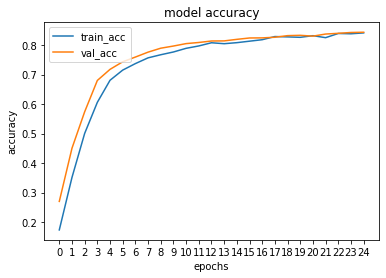

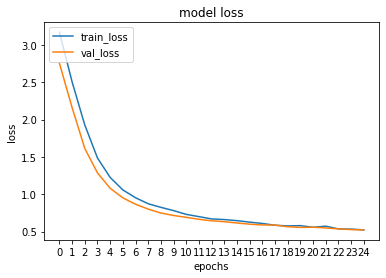

In [40]:
plt.plot(train_loss_accum)
plt.plot(val_loss_accum)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.xticks(range(N_EPOCHS))
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

### Test model on test set 
Load our "best" parameters and evaluate performance on the test set.

In [41]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, TAG_PAD_IDX)

print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.445 |  Test Acc: 86.13%


## BiGRU + FC model

In [42]:
class BiGRU(nn.Module):
    def __init__(self, 
                 input_dim, 
                 embedding_dim, 
                 hidden_dim, 
                 output_dim, 
                 dropout,
                 pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx = pad_idx)
        self.embedding.weight.requires_grad = False
        self.gru = nn.GRU(input_size=embedding_dim, hidden_size=hidden_dim, 
                          bidirectional=True, num_layers=1)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        # pass text through embedding layer
        embedded = self.dropout(self.embedding(text))
        # pass embeddings into LSTM
        outputs, (hidden, cell) = self.gru(embedded)
        predictions = self.fc(self.dropout(outputs))
        return predictions

INPUT_DIM = len(text.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = len(label.vocab)
DROPOUT = 0.25
PAD_IDX = text.vocab.stoi[text.pad_token]
TAG_PAD_IDX = label.vocab.stoi[label.pad_token]

model = BiGRU(INPUT_DIM, 
                        EMBEDDING_DIM, 
                        HIDDEN_DIM, 
                        OUTPUT_DIM, 
                        DROPOUT, 
                        PAD_IDX)

# Initialization
pretrained_embeddings = text.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
optimizer = optim.Adam(model.parameters())
TAG_PAD_IDX = label.vocab.stoi[label.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)
model = model.to(device)
criterion = criterion.to(device)

### Train

In [43]:
N_EPOCHS = 25

best_valid_loss = float('inf')
train_loss_accum2, val_loss_accum2 = [], []
for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, TAG_PAD_IDX)
    valid_loss = evaluate(model, valid_iterator, criterion, TAG_PAD_IDX)
    # save train/val loss and accuracy to plot
    train_loss_accum2.append(train_loss)
    val_loss_accum2.append(valid_loss) 
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f})
    print(f'\t Val. Loss: {valid_loss:.3f})

Epoch: 01 | Epoch Time: 0m 36s
	Train Loss: 3.088 | Train Acc: 18.38%
	 Val. Loss: 2.600 |  Val. Acc: 36.54%
Epoch: 02 | Epoch Time: 0m 34s
	Train Loss: 2.311 | Train Acc: 41.56%
	 Val. Loss: 1.866 |  Val. Acc: 52.48%
Epoch: 03 | Epoch Time: 0m 35s
	Train Loss: 1.621 | Train Acc: 57.55%
	 Val. Loss: 1.306 |  Val. Acc: 66.06%
Epoch: 04 | Epoch Time: 0m 35s
	Train Loss: 1.192 | Train Acc: 68.57%
	 Val. Loss: 1.039 |  Val. Acc: 71.76%
Epoch: 05 | Epoch Time: 0m 39s
	Train Loss: 1.000 | Train Acc: 72.60%
	 Val. Loss: 0.890 |  Val. Acc: 75.35%
Epoch: 06 | Epoch Time: 0m 36s
	Train Loss: 0.885 | Train Acc: 74.80%
	 Val. Loss: 0.806 |  Val. Acc: 77.28%
Epoch: 07 | Epoch Time: 0m 38s
	Train Loss: 0.812 | Train Acc: 76.82%
	 Val. Loss: 0.740 |  Val. Acc: 78.82%
Epoch: 08 | Epoch Time: 0m 37s
	Train Loss: 0.752 | Train Acc: 78.12%
	 Val. Loss: 0.697 |  Val. Acc: 79.84%
Epoch: 09 | Epoch Time: 0m 37s
	Train Loss: 0.720 | Train Acc: 78.94%
	 Val. Loss: 0.668 |  Val. Acc: 80.35%
Epoch: 10 | Epoch T

### Plot loss and accuracy of train and val

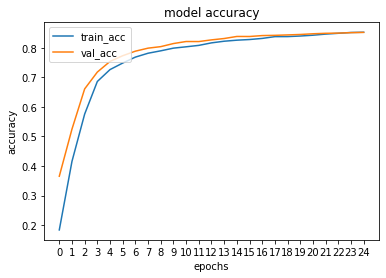

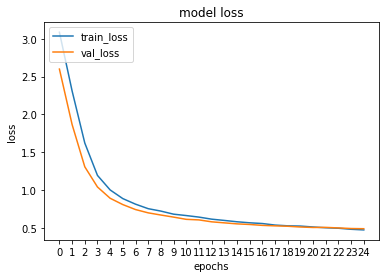

In [44]:
plt.plot(train_loss_accum2)
plt.plot(val_loss_accum2)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.xticks(range(N_EPOCHS))
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

### Test model on test set 
Load our "best" parameters and evaluate performance on the test set.

In [45]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, TAG_PAD_IDX)

print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.407 |  Test Acc: 87.35%


## BiLSTMx2 + FC model

In [46]:
class BiLSTMx2(nn.Module):
    def __init__(self, 
                 input_dim, 
                 embedding_dim, 
                 hidden_dim, 
                 output_dim, 
                 n_layers, 
                 dropout, 
                 pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx = pad_idx)
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embedding_dim, 
                            hidden_dim, 
                            num_layers = n_layers, 
                            bidirectional = True,
                            dropout = dropout if n_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        # pass text through embedding layer
        embedded = self.dropout(self.embedding(text))
        # pass embeddings into LSTM
        outputs, (hidden, cell) = self.lstm(embedded)
        predictions = self.fc(self.dropout(outputs))
        return predictions
    
INPUT_DIM = len(text.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = len(label.vocab)
N_LAYERS = 2 # here we will jave two LSTM layers
DROPOUT = 0.25
PAD_IDX = text.vocab.stoi[text.pad_token]
TAG_PAD_IDX = label.vocab.stoi[label.pad_token]
model = BiLSTMx2(INPUT_DIM, 
                        EMBEDDING_DIM, 
                        HIDDEN_DIM, 
                        OUTPUT_DIM, 
                        N_LAYERS, 
                        DROPOUT, 
                        PAD_IDX)

# Initialization
pretrained_embeddings = text.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
optimizer = optim.Adam(model.parameters())
TAG_PAD_IDX = label.vocab.stoi[label.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)
model = model.to(device)
criterion = criterion.to(device)

### Train

In [47]:
N_EPOCHS = 25

best_valid_loss = float('inf')
train_loss_accum3, val_loss_accum3 = [], []
for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, TAG_PAD_IDX)
    valid_loss = evaluate(model, valid_iterator, criterion, TAG_PAD_IDX)
    train_loss_accum3.append(train_loss)
    val_loss_accum3.append(valid_loss)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f})
    print(f'\t Val. Loss: {valid_loss:.3f})

Epoch: 01 | Epoch Time: 1m 22s
	Train Loss: 3.220 | Train Acc: 12.48%
	 Val. Loss: 2.957 |  Val. Acc: 15.51%
Epoch: 02 | Epoch Time: 1m 27s
	Train Loss: 2.799 | Train Acc: 22.35%
	 Val. Loss: 2.455 |  Val. Acc: 36.85%
Epoch: 03 | Epoch Time: 1m 25s
	Train Loss: 2.142 | Train Acc: 42.04%
	 Val. Loss: 1.740 |  Val. Acc: 50.88%
Epoch: 04 | Epoch Time: 1m 28s
	Train Loss: 1.631 | Train Acc: 54.45%
	 Val. Loss: 1.368 |  Val. Acc: 62.10%
Epoch: 05 | Epoch Time: 1m 23s
	Train Loss: 1.323 | Train Acc: 62.99%
	 Val. Loss: 1.115 |  Val. Acc: 69.87%
Epoch: 06 | Epoch Time: 1m 24s
	Train Loss: 1.104 | Train Acc: 69.30%
	 Val. Loss: 0.973 |  Val. Acc: 72.06%
Epoch: 07 | Epoch Time: 1m 21s
	Train Loss: 1.000 | Train Acc: 71.44%
	 Val. Loss: 0.861 |  Val. Acc: 75.20%
Epoch: 08 | Epoch Time: 1m 23s
	Train Loss: 0.902 | Train Acc: 74.14%
	 Val. Loss: 0.784 |  Val. Acc: 77.60%
Epoch: 09 | Epoch Time: 1m 21s
	Train Loss: 0.834 | Train Acc: 75.97%
	 Val. Loss: 0.735 |  Val. Acc: 78.76%
Epoch: 10 | Epoch T

### Plot loss for train and val

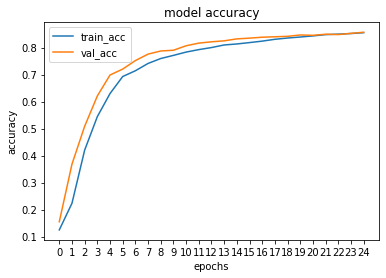

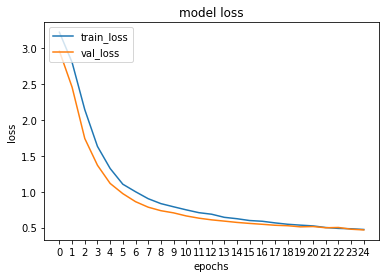

In [48]:
plt.plot(train_loss_accum3)
plt.plot(val_loss_accum3)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.xticks(range(N_EPOCHS))
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

### Test model on test set 
Load our "best" parameters and evaluate performance on the test set.

In [49]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, TAG_PAD_IDX)

print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.394 |  Test Acc: 87.37%


##  BiLSTM + FC + CRF model

In [7]:
def train(model, iterator, optimizer, mean_n_tokens, tag_pad_idx):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        text = batch.text
        tags = batch.label
        
        loss = model(text, tags) / mean_n_tokens
        
        predictions = model.predict(text)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, optimizer, mean_n_tokens, tag_pad_idx):
    
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text = batch.text
            tags = batch.label
            
            loss = model(text, tags) / mean_n_tokens
            predictions = model.predict(text) 
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [8]:
from torchcrf import CRF
class BiLSTM_CRF(nn.Module):
    def __init__(self, 
                 input_dim, 
                 embedding_dim, 
                 hidden_dim, 
                 output_dim, 
                 dropout, 
                 pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx = pad_idx)
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embedding_dim, 
                            hidden_dim, 
                            num_layers = 1, 
                            bidirectional = True)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.crf = CRF(output_dim) # output_dim is len of labels
    def forward(self, text, labels):
        # pass text through embedding layer
        embedded = self.dropout(self.embedding(text))
        # pass embeddings into LSTM
        outputs, (hidden, cell) = self.lstm(embedded)
        scores = self.fc(self.dropout(outputs))
        return -self.crf(scores, labels)
    
    def predict(self, text):
        # pass text through embedding layer
        embedded = self.dropout(self.embedding(text))
        # pass embeddings into LSTM
        outputs, (hidden, cell) = self.lstm(embedded)
        scores = self.fc(self.dropout(outputs))
        return self.crf.decode(scores)
    
INPUT_DIM = len(text.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = len(label.vocab)
DROPOUT = 0.25
PAD_IDX = text.vocab.stoi[text.pad_token]
TAG_PAD_IDX = label.vocab.stoi[label.pad_token]

model = BiLSTM_CRF(INPUT_DIM, 
                        EMBEDDING_DIM, 
                        HIDDEN_DIM, 
                        OUTPUT_DIM, 
                        DROPOUT, 
                        PAD_IDX)

# Initialization
pretrained_embeddings = text.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
optimizer = optim.Adam(model.parameters())
TAG_PAD_IDX = label.vocab.stoi[label.pad_token]
model = model.to(device)

### Train

In [9]:
N_EPOCHS = 2

best_valid_loss = float('inf')
train_loss_accum4, val_loss_accum4, = [], []
# Count the number of words and sentences.
n_tokens_train = 0
n_sentences_train = 0
for ex in train_data:
    n_tokens_train += len(ex.text) + 2
    n_sentences_train += 1
n_tokens_valid = 0       
for ex in val_data:
    n_tokens_valid += len(ex.text)

n_batches = np.ceil(n_sentences_train / BATCH_SIZE)
mean_n_tokens = (n_tokens_train / n_batches) * BATCH_SIZE

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, mean_n_tokens, TAG_PAD_IDX)
    valid_loss = evaluate(model, valid_iterator, optimizer, mean_n_tokens, TAG_PAD_IDX)
    train_loss_accum4.append(train_loss)
    val_loss_accum4.append(valid_loss)
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f})
    print(f'\t Val. Loss: {valid_loss:.3f})

Epoch: 01 | Epoch Time: 1m 46s
	Train Loss: 1.763 | Train Acc: 0.00%
	 Val. Loss: 0.948 |  Val. Acc: 0.00%
Epoch: 02 | Epoch Time: 2m 3s
	Train Loss: 0.690 | Train Acc: 0.00%
	 Val. Loss: 0.823 |  Val. Acc: 0.00%


### Plot loss and accuracy of train and val

In [ ]:
# Accuracy
plt.plot(train_acc_accum4)
plt.plot(val_acc_accum4)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.xticks(range(N_EPOCHS))
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.show()
# Loss
plt.plot(train_loss_accum)
plt.plot(val_loss_accum)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.xticks(range(N_EPOCHS))
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

### Test model on test set 
Load our "best" parameters and evaluate performance on the test set.

In [ ]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, TAG_PAD_IDX)

print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

In [ ]:
### Plot model accuracies

In [ ]:
# Accuracy
plt.plot(train_acc_accum1)
plt.plot(train_acc_accum2)
plt.plot(train_acc_accum3)
#plt.plot(train_acc_accum4)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.xticks(range(N_EPOCHS))
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.show()



#### Calculate f1 score for the best model and error analysis

## Inference

88% accuracy looks pretty good, but let's see our model tag some actual sentences.

We define a `tag_sentence` function that will:
- put the model into evaluation mode
- tokenize the sentence with spaCy if it is not a list
- lowercase the tokens if the `Field` did
- numericalize the tokens using the vocabulary
- find out which tokens are not in the vocabulary, i.e. are `<unk>` tokens
- convert the numericalized tokens into a tensor and add a batch dimension
- feed the tensor into the model
- get the predictions over the sentence
- convert the predictions into readable tags

As well as returning the tokens and tags, it also returns which tokens were `<unk>` tokens.

In [10]:
def tag_sentence(model, device, sentence, text_field, tag_field):
    
    model.eval()
    
    if isinstance(sentence, str):
        nlp = spacy.load('en')
        tokens = [token.text for token in nlp(sentence)]
    else:
        tokens = [token for token in sentence]

    if text_field.lower:
        tokens = [t.lower() for t in tokens]
        
    numericalized_tokens = [text_field.vocab.stoi[t] for t in tokens]

    unk_idx = text_field.vocab.stoi[text_field.unk_token]
    
    unks = [t for t, n in zip(tokens, numericalized_tokens) if n == unk_idx]
    
    token_tensor = torch.LongTensor(numericalized_tokens)
    
    token_tensor = token_tensor.unsqueeze(-1).to(device)
         
    predictions = model(token_tensor)
    
    top_predictions = predictions.argmax(-1)
    
    predicted_tags = [tag_field.vocab.itos[t.item()] for t in top_predictions]
    
    return tokens, predicted_tags, unks

We'll get an already tokenized example from the training set and test our model's performance.

In [11]:
example_index = 1

sentence = vars(train_data.examples[example_index])['text']
actual_tags = vars(train_data.examples[example_index])['label']

print(sentence)

['rudolph', 'agnew', ',', '55', 'years', 'old', 'and', 'former', 'chairman', 'of', 'consolidated', 'gold', 'fields', 'plc', ',', 'was', 'named', 'a', 'nonexecutive', 'director', 'of', 'this', 'british', 'industrial', 'conglomerate', '.']


We can then use our `tag_sentence` function to get the tags. Notice how the tokens referring to subject of the sentence, the "respected cleric", are both `<unk>` tokens!

In [12]:
tokens, pred_tags, unks = tag_sentence(model, 
                                       device, 
                                       sentence, 
                                       text, 
                                       label)

print(unks)

TypeError: forward() missing 1 required positional argument: 'labels'

We can then check how well it did. Surprisingly, it got every token correct, including the two that were unknown tokens!

In [26]:
print("Pred. Tag\tActual Tag\tCorrect?\tToken\n")

for token, pred_tag, actual_tag in zip(tokens, pred_tags, actual_tags):
    correct = '✔' if pred_tag == actual_tag else '✘'
    print(f"{pred_tag}\t\t{actual_tag}\t\t{correct}\t\t{token}")

Pred. Tag	Actual Tag	Correct?	Token

NNP		NNP		✔		rudolph
NNP		NNP		✔		agnew
,		,		✔		,
NNP		CD		✘		55
NNP		NNS		✘		years
NNP		JJ		✘		old
NNP		CC		✘		and
NNP		JJ		✘		former
NNP		NN		✘		chairman
IN		IN		✔		of
NNP		NNP		✔		consolidated
NNP		NNP		✔		gold
NNP		NNP		✔		fields
NNP		NNP		✔		plc
,		,		✔		,
NNP		VBD		✘		was
NNP		VBN		✘		named
DT		DT		✔		a
NNP		JJ		✘		nonexecutive
NNP		NN		✘		director
IN		IN		✔		of
DT		DT		✔		this
NNP		JJ		✘		british
NN		JJ		✘		industrial
NN		NN		✔		conglomerate
.		.		✔		.


## F1 score

In [ ]:
def remove_punctuation(preds, y):
    preds_no_punct = []
    y_no_punct = []
    for i in range(len(preds)):
        if(bool(re.match('^[a-zA-Z0-9]*$', i)) == True): # if not contains punct chars.
            preds_no_punct.append(preds[i])
            y_no_punct.append(y[i])
    return preds_no_punct, y_no_punct

In [62]:
from sklearn.metrics import f1_score
import re
preds = []
y = []
for i in range(len(test_data.examples)):
    actual_tags = vars(test_data.examples[i])['label']
    sentence = vars(test_data.examples[i])['text']
    _, pred_tags, _ = tag_sentence(model, device, sentence, text, label)
    preds.append(pred_tags)
    y.append(actual_tags)
preds_unflatten = [item for sublist in preds for item in sublist]
y_unflatten = [item for sublist in y for item in sublist]
preds, y = remove_punctuation(preds_unflatten, y_unflatten)
print("F1-score: ", "{:.2f}".format(f1_score(y, preds, average='macro')))

TypeError: expected string or bytes-like object